In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridSpec

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import gym
from gym import spaces

from collections import deque
import random

%matplotlib inline

In [2]:
pd.options.display.max_columns = 40

In [3]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# 1. Data Preprocessing

In [4]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [5]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [6]:
summary = resumetable(data)
summary

data shape: (10000, 15)


,data type,num_NaN,num_unique,data category
CreditScore,int64,0,460,None
Geography,object,0,3,Categorical
Gender,object,0,2,Categorical
Age,int64,0,70,None
Tenure,int64,0,11,None
Balance,float64,0,6382,Numeric
NumOfProducts,int64,0,4,None
HasCrCard,int64,0,2,None
IsActiveMember,int64,0,2,None
EstimatedSalary,float64,0,9999,Numeric


We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

C:\Users\ikjoo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


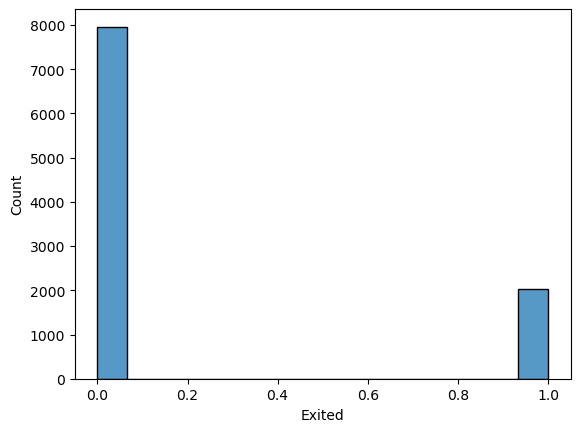

In [7]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [8]:
zero = data[data['Balance'] == 0]

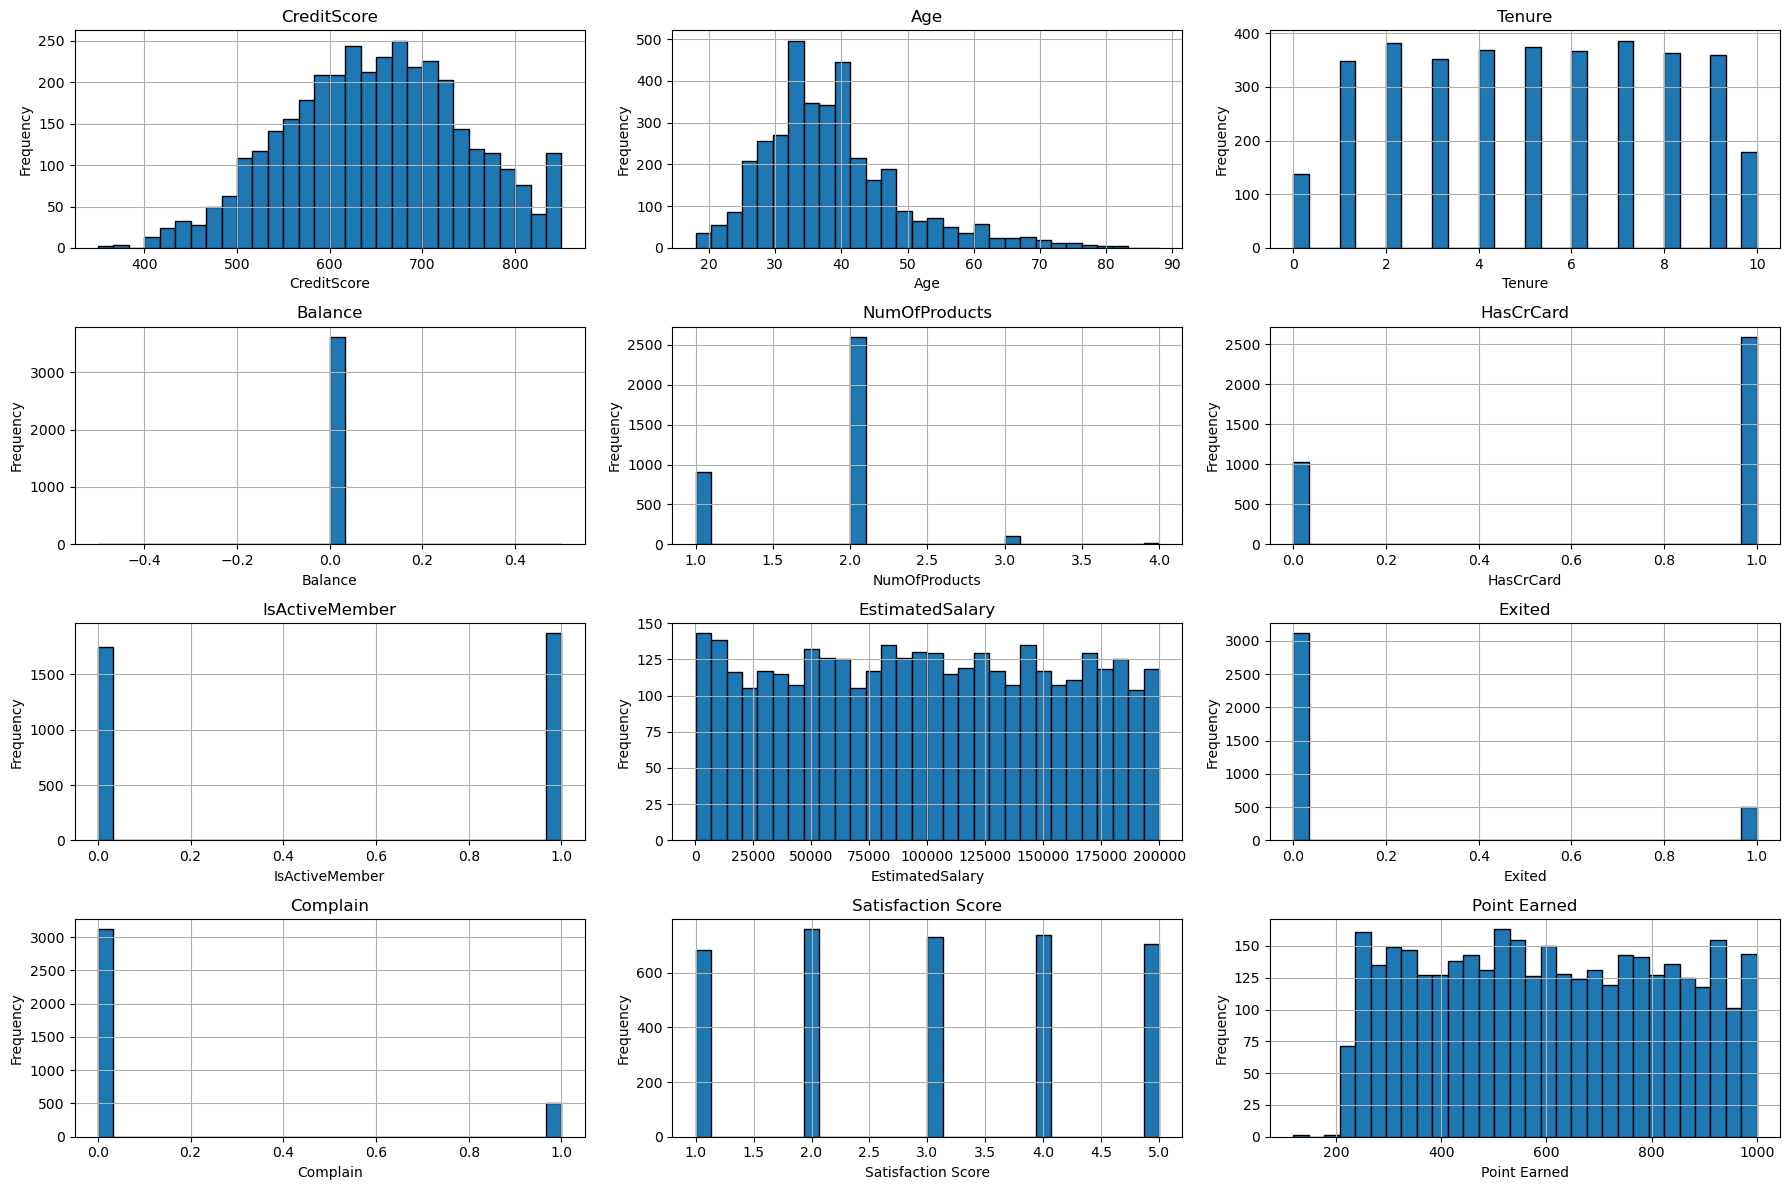

In [9]:
numeric_columns = zero.select_dtypes(include=['float64', 'int64']).columns

# Re-plot using subplots with a larger figure to avoid scrolling
plt.figure(figsize=(18, 12))  # Larger figure to fit all plots
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid size to fit all features
    zero[column].hist(bins=30, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
round(data.describe(), 2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.0,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2,0.2,3.01,606.52
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4,0.4,1.41,225.92
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0,0.0,1.00,119.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0,0.0,2.00,410.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0,0.0,3.00,605.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0,0.0,4.00,801.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.0,5.00,1000.00


We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [11]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

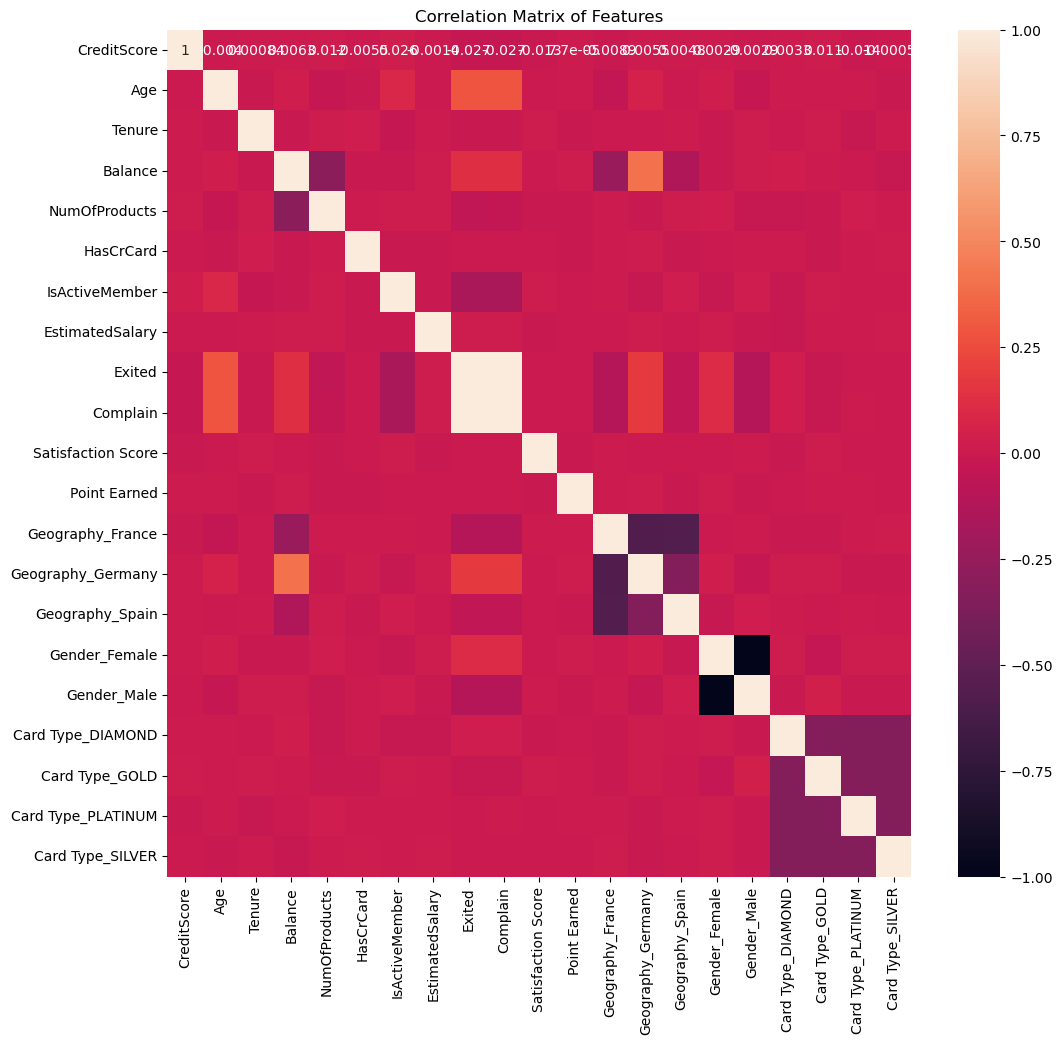

In [12]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [13]:
# data.drop(['Complain'], axis = 1, inplace = True) 보류 

### Data Scaling

C:\Users\ikjoo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ikjoo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


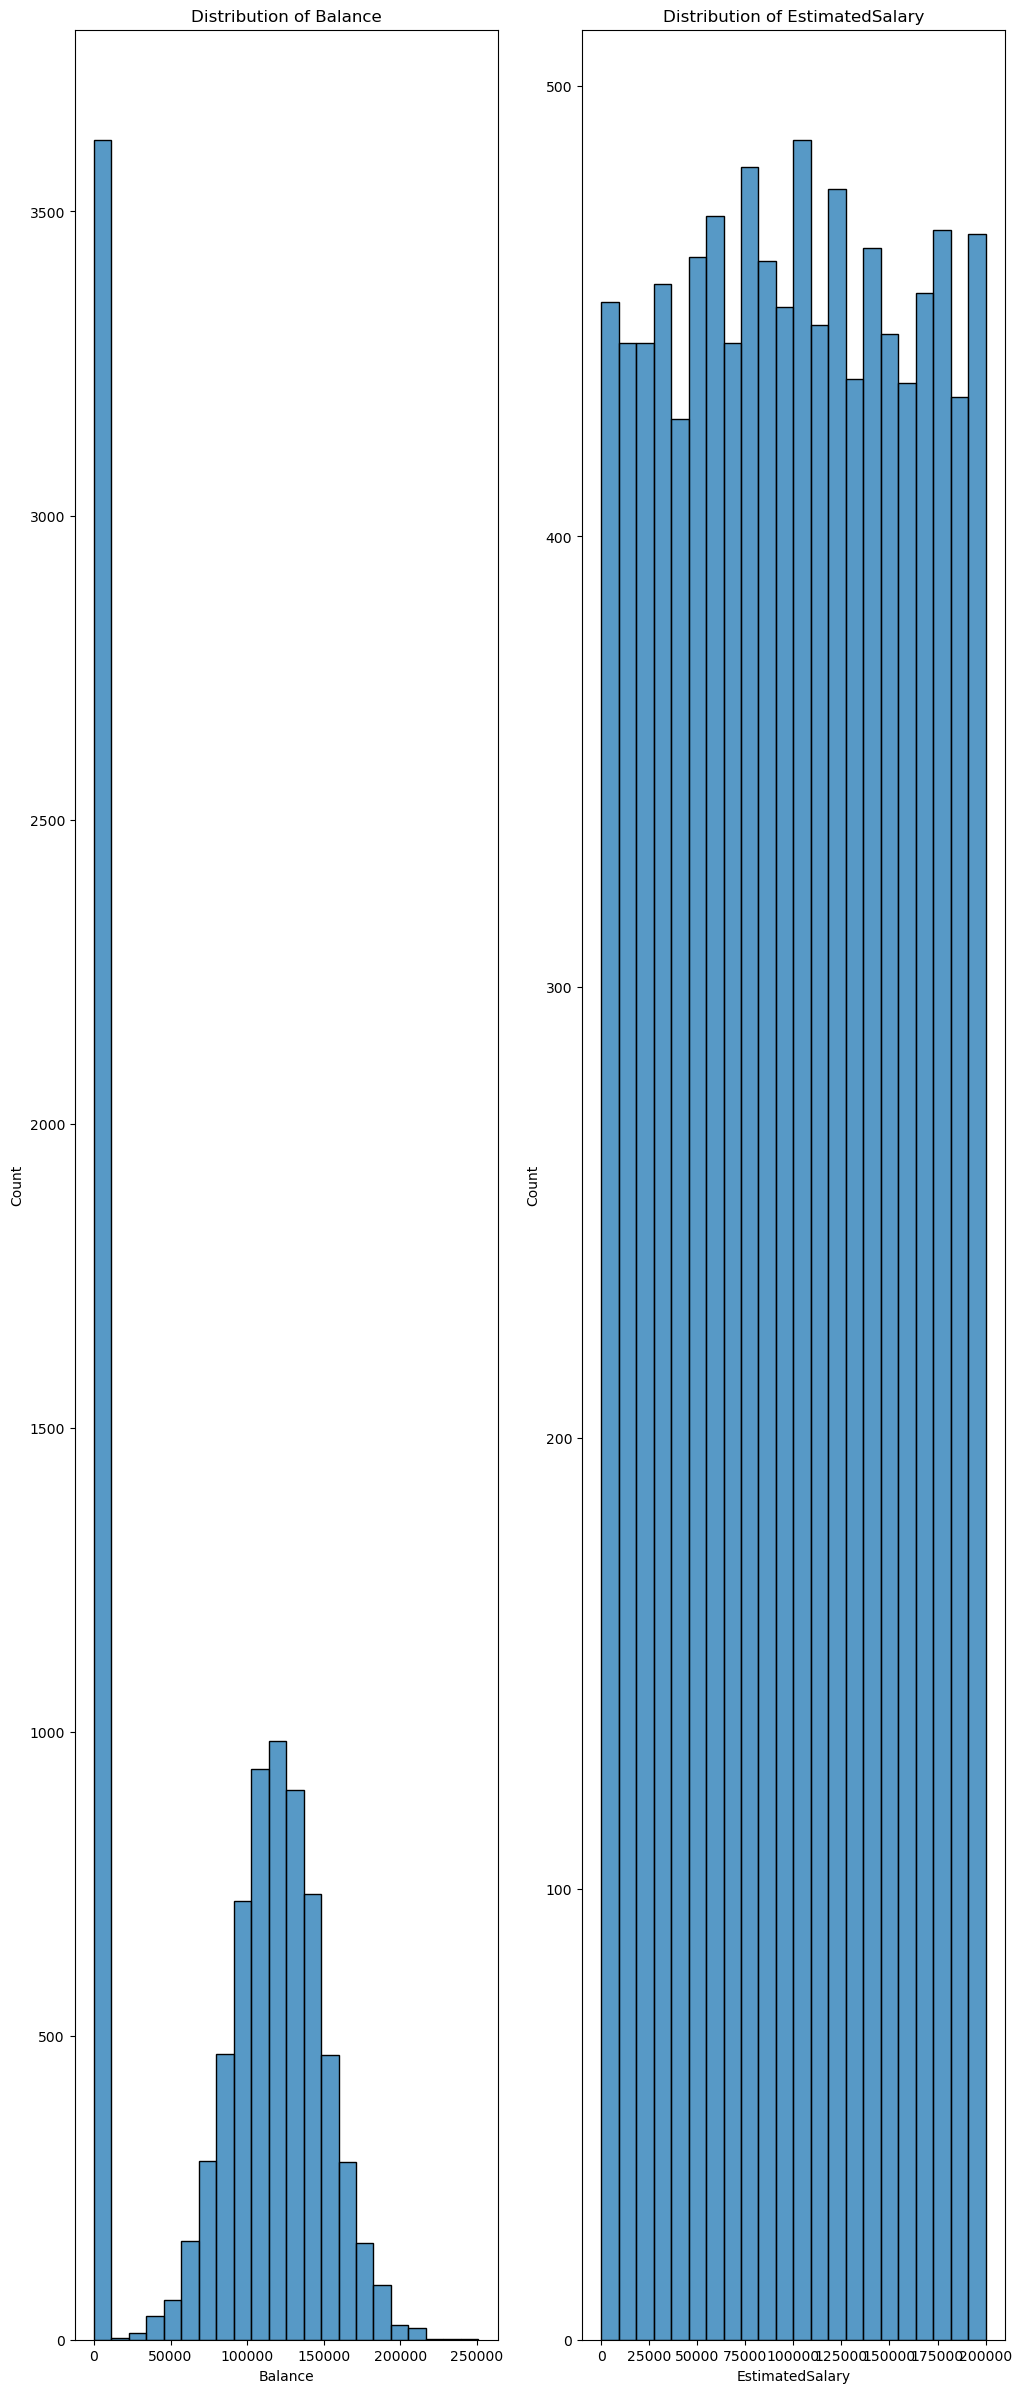

In [14]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

### 우선 스케일링또한 보류

- numofproducts 변수는 1, 2, 3, 4 등의 숫자간에 discrete 성격을 보여주기때문에 범주형 변수로 간주한다.
satisfaction score 변수도 명확한 범주를 보여줌. (1, 2, 3, 4, 5) 
이 두 변수는 원-핫 인코딩을 진행

- Balance 변수를 보면 0에 많은 데이터가 몰려있는 걸 알 수 있다. 이는 모델이 잔액 0 여부를 구분하도록 하기 위해 이진 변수로 추가

- CreditScore: Standard Scaling 

- Age: Standard Scaling 
    WHY? Age는 정규 분포에 가깝고 나이 간의 상대적 차이를 유지하는게 중요해보임. 그리고 30~40대에 몰려있는게 가장 큰 이유

- EstimatedSalary: Min-Max Scaling 
    WHY? 분포가 다른 피처들 중 가장 균등함
  
- Point Earned: Robust Scaling 
    WHY? Point Earned는 최소값 근처에 데이터가 적고 나머지 값들은 균등하게 분포되어 있어 이상치의 영향을 줄이기 위해 Robust Scaling 사용

- Balance: Robust Scaling 
    WHY? Balance는 0에 많은 데이터가 몰려 있어서 중앙값과 IQR을 기준으로 스케일링하여 이상치의 영향을 줄이기


In [15]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

In [16]:
# standard_scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
# data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
# data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [17]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


### Feature Engineering

In [18]:
# data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [19]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


In [20]:
# bins = [0, 2, 4, 6, 8, 10]
# labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
# data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
# data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

### Feature importance by random forest

In [21]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

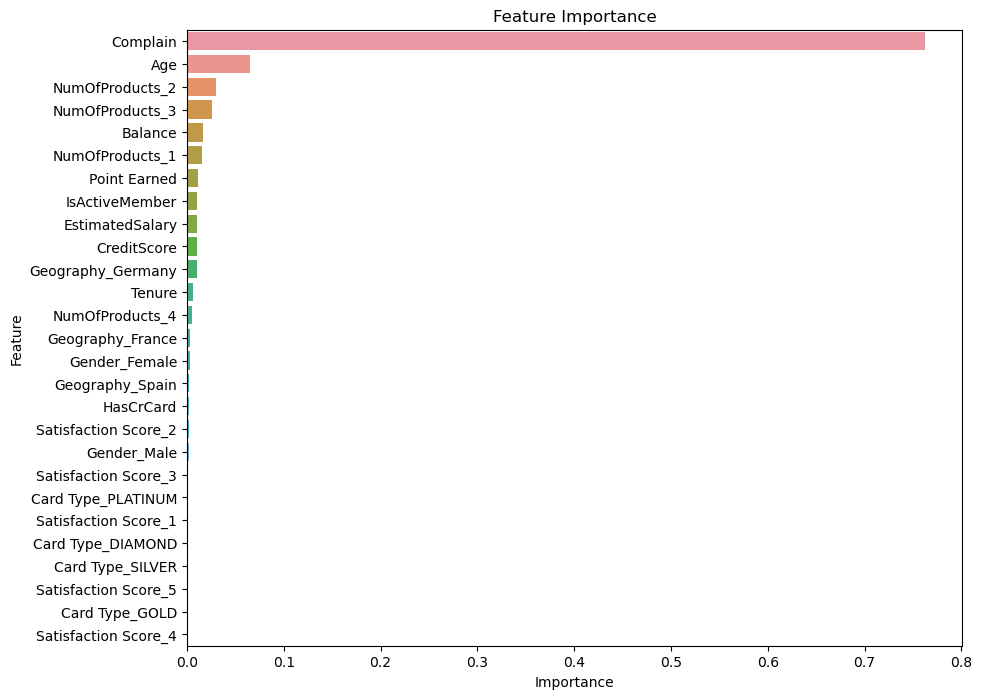

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')
plt.title('Feature Importance')
plt.show();

# 2. Exploratory Data Analysis

Correlation between Age and Exited: 0.285


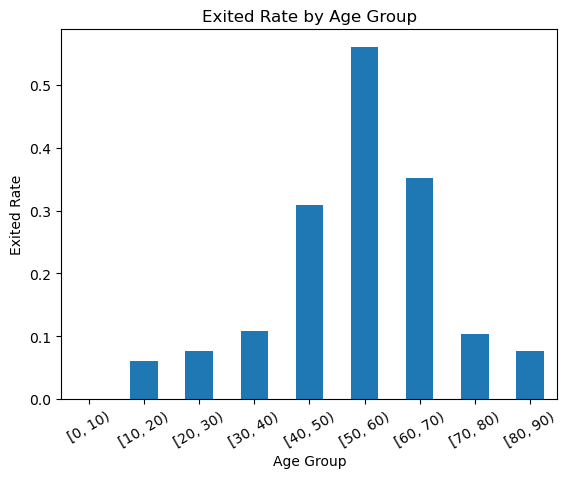

In [23]:
# Age vs Exited

age_groups = pd.cut(data['Age'], bins=range(0, 100, 10), right=False)
age_exit_ratio = data.groupby(age_groups, observed=False)['Exited'].mean()

age_exit_ratio.plot(kind = 'bar')
plt.xlabel('Age Group')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Age Group')
plt.xticks(rotation = 30);

correlation = data[['Age', 'Exited']].corr().iloc[0, 1]
print(f"Correlation between Age and Exited: {correlation:.3f}")

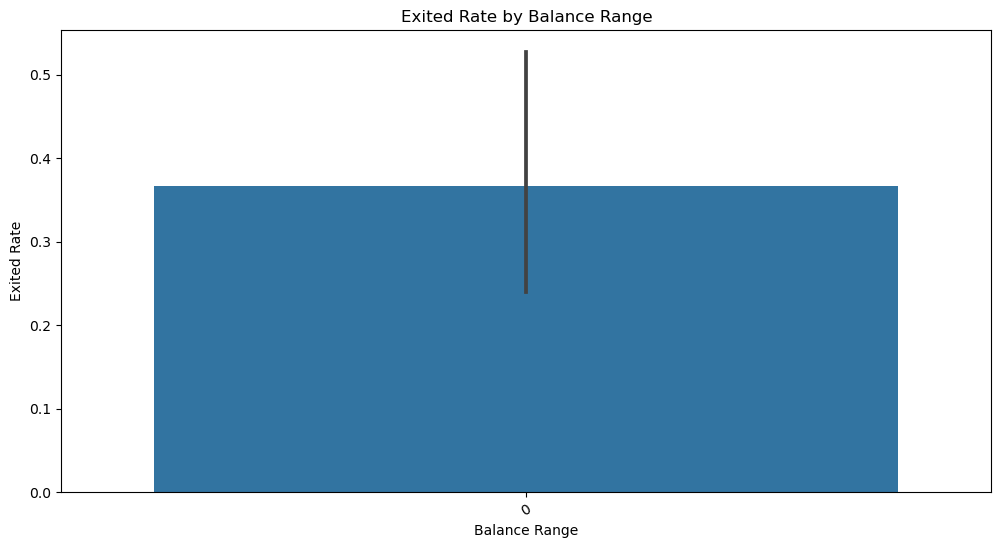

In [24]:
# Balance Range vs Exited

balance_bins = pd.cut(data['Balance'], bins=[0, 1000, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000], right=False)
balance_exit_ratio = data.groupby(balance_bins, observed=False)['Exited'].mean()

plt.figure(figsize = (12, 6))
sns.barplot(data = balance_exit_ratio)
plt.xlabel('Balance Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance Range')
plt.xticks(rotation=30);

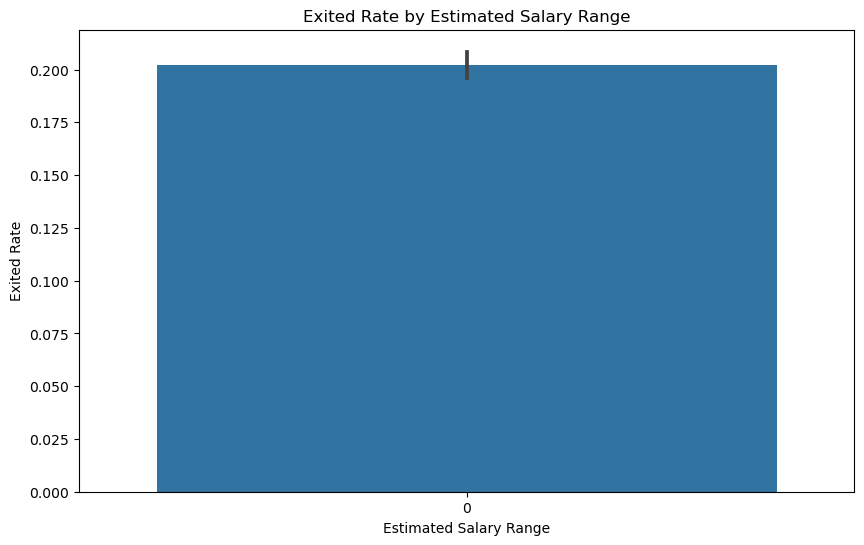

In [25]:
# Estimated Salary VS Exited
salary_bins = pd.cut(data['EstimatedSalary'], bins=[0, 20000, 40000, 60000, 100000, 150000, 200000], right=False)
salary_exit_ratio = data.groupby(salary_bins, observed=False)['Exited'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(data = salary_exit_ratio)
plt.xlabel('Estimated Salary Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Estimated Salary Range')
plt.xticks(rotation=0);

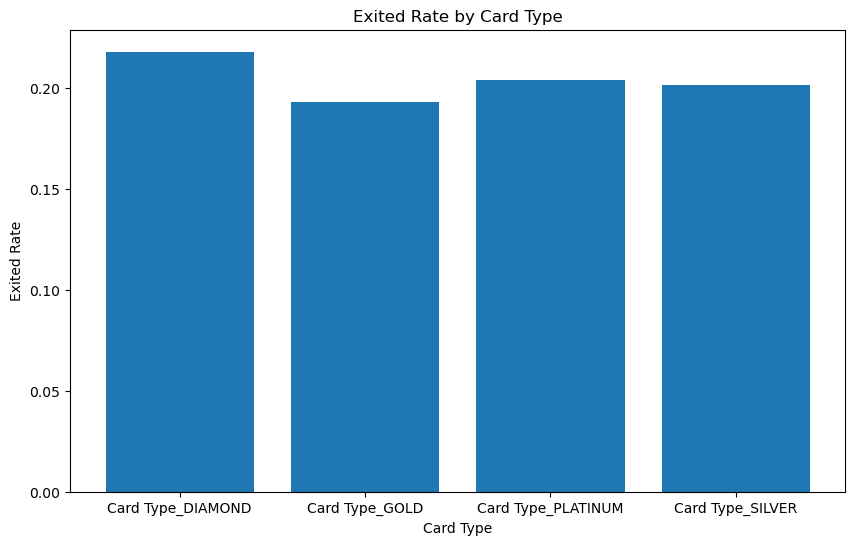

In [26]:
# Card Type VS Exited

card_types = ['Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']
card_exit_ratios = {}

for card_type in card_types:
    card_exit_ratios[card_type] = data.loc[data[card_type] == 1, 'Exited'].mean()

card_exit_df = pd.DataFrame(list(card_exit_ratios.items()), columns=['Card Type', 'Exited Rate'])

plt.figure(figsize = (10, 6))
plt.bar(card_exit_df['Card Type'], card_exit_df['Exited Rate'])
plt.xlabel('Card Type')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Card Type')
plt.xticks(rotation=0);

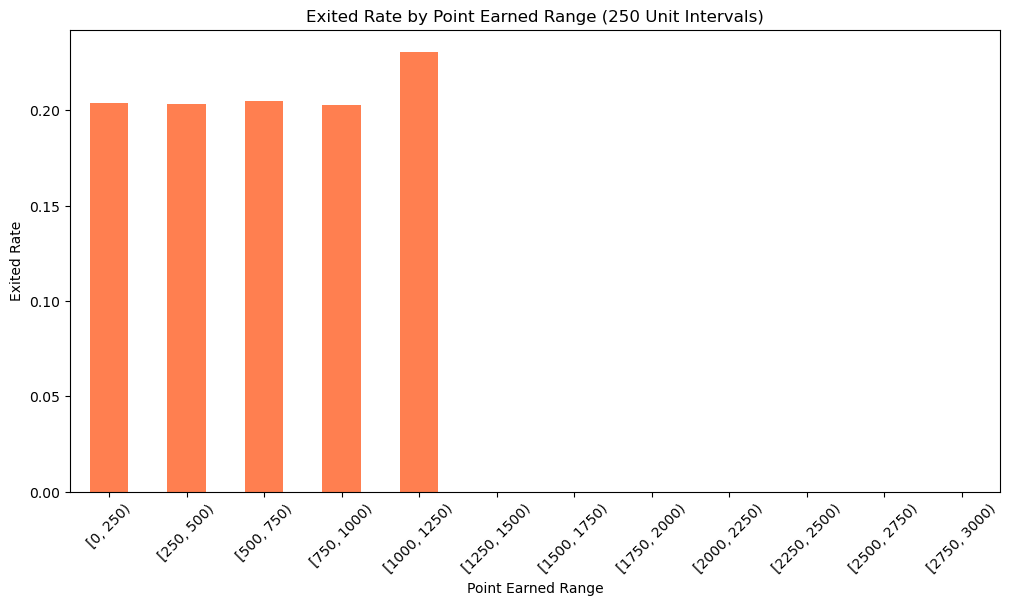

In [27]:
point_bins = pd.cut(data['Point Earned'], bins=range(0, 3001, 250), right=False)

# Calculate Exited rate for each bin, with observed=False to suppress the warning
point_exit_ratio = data.groupby(point_bins, observed=False)['Exited'].mean()

# Plotting the exit rate by Point Earned range
plt.figure(figsize=(12, 6))
point_exit_ratio.plot(kind='bar', color='coral')
plt.xlabel('Point Earned Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Point Earned Range (250 Unit Intervals)')
plt.xticks(rotation=45)
plt.show()

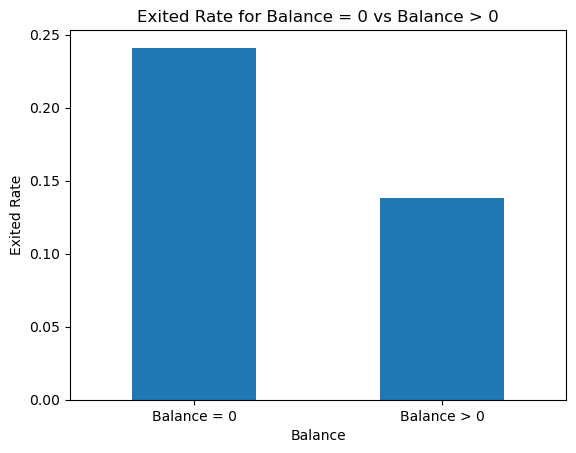

Balance
False    0.240953
True     0.138236
Name: Exited, dtype: float64


In [28]:
balance_exit_rate = data.groupby(data['Balance'] == 0)['Exited'].mean()

balance_exit_rate.plot(kind='bar')
plt.xticks([0, 1], ['Balance = 0', 'Balance > 0'], rotation=0)
plt.ylabel('Exited Rate')
plt.title('Exited Rate for Balance = 0 vs Balance > 0')
plt.show()

print(balance_exit_rate)

# EDA Ikjoo Oh 10/28

## 10/29 Meeting 후
- 알고리즘 xgboost사용 생각해볼것

- 현재 진행해야하는 EDA 검토 ("Complain"을 제외한 importance 상위권으로 진행)
    - creditscore (done)
    - age (기존에 해결)
    - tenure (done)
    - balance
    - estimated
    - point earned (done)
    - num of products (done)



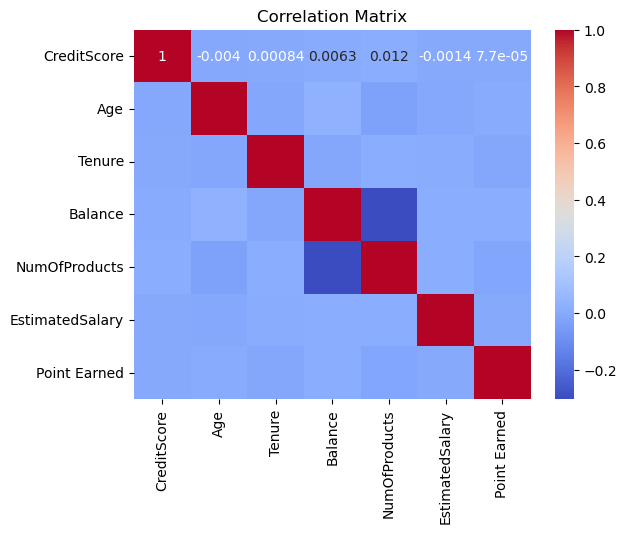

In [29]:
# EDA를 위해 기존의 데이터셋을 불러옴
data2 = pd.read_csv(data_path)

# 상위권 features들로 heatmap제작
correlation_matrix = data2[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [30]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


### 1. CreditScore

#### 1.1표준 Range of Credit Score
- Poor credit: 300 to 579
- Fair credit: 580 to 669
- Good credit: 670 to 739
- Very good credit: 740 to 799
- Excellent credit: 800 to 850

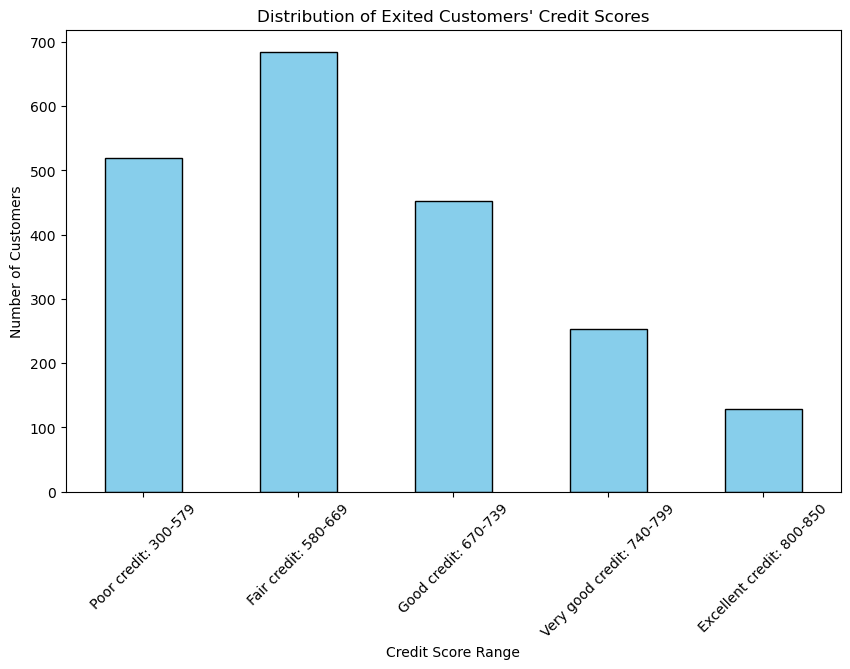

In [31]:
# Exited가 1인 고객들만을 선택하여 exited_data로 정의
exited_data = data[data['Exited'] == 1].copy()

# CreditScore의 구간 정의 및 label
bins = [300, 580, 670, 740, 800, 851]
labels = ['Poor credit: 300-579', 'Fair credit: 580-669', 'Good credit: 670-739', 'Very good credit: 740-799', 'Excellent credit: 800-850']

# Exited가 1인 고객들의 CreditScore를 구간별로 나누고 빈도 계산
exited_data['CreditScore_Binned'] = pd.cut(exited_data['CreditScore'], bins=bins, labels=labels, right=False)
credit_score_distribution = exited_data['CreditScore_Binned'].value_counts().sort_index()

# Visualization
plt.figure(figsize=(10, 6))
credit_score_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Exited Customers' Credit Scores")
plt.xlabel("Credit Score Range")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


In [32]:
# 전체 데이터에서 CreditScore를 구간별로 나누기
data['CreditScore_Binned'] = pd.cut(data['CreditScore'], bins=bins, labels=labels, right=False)

# 각 구간별 전체 고객 수 계산
total_customers_per_bin = data['CreditScore_Binned'].value_counts().sort_index()

# 각 구간별 이탈 고객 수 계산
exited_customers_per_bin = exited_data['CreditScore_Binned'].value_counts().sort_index()

# 각 구간별 이탈율 계산 (전체 고객 중 이탈한 비율)
exited_rate_per_bin = (exited_customers_per_bin / total_customers_per_bin * 100).round(2)

# 결과 출력
print("구간별 전체 고객 대비 이탈률 (%):")
print(exited_rate_per_bin)


구간별 전체 고객 대비 이탈률 (%):
CreditScore_Binned
Poor credit: 300-579         22.02
Fair credit: 580-669         20.56
Good credit: 670-739         18.62
Very good credit: 740-799    20.67
Excellent credit: 800-850    19.54
Name: count, dtype: float64


#### 1.2
- 그래프를 보면 기존처럼 숫자를 기준으로 나눈것이 아닌 표준단위로 나눈결과 신용점수에 따라 이탈률### 1.2
- 그래프를 보면 기존처럼 숫자를 기준으로 나눈것이 아닌 표준단위로 나눈결과 신용점수에 따라 이탈률이 감소하는 추세를 보임
   - 사유: 구간별 전체고객(Exited가 1,0 사람들 전부포함) 대비 이탈률을 검토한결과 전 구간 20%로 확인됨, 즉 그래프에서의 차이는 구간별로 customer의 숫자차이로 인해 생긴 차이로 발생했다고 해석될 수 있다.
   - **해석1**: 전 구간에 이탈률이 20%로 같기 때문에 credit score를 제외하는것이 옳다
   - **해석2**: 이탈률이 20%로 같지만 당초 목표는 어떻게 해야 이탈을 줄일 수 있는지에 관한 고찰이고, 고객수가 많은 구간에 더 많은 reward를 부여한다면 이탈하는 customer의 총 숫자를 줄일 수 있을것으로 예상된다
- 결론: 향후 강화학습을 통해 해석1과 2의 차이를 보고 결정해야할듯함

### 2. Number of Products

In [33]:
# EDA를 위해 기존의 데이터셋을 불러옴
data2 = pd.read_csv(data_path)

In [34]:
data2.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [35]:
# Product 구매별 이탈율과 이탈숫자
print(data2.groupby('NumOfProducts')['Exited'].mean())
print(data2.groupby('NumOfProducts')['Exited'].sum())

NumOfProducts
1    0.277144
2    0.076035
3    0.827068
4    1.000000
Name: Exited, dtype: float64
NumOfProducts
1    1409
2     349
3     220
4      60
Name: Exited, dtype: int64


#### 2.1
- product의 개수가 3개이상부터는 극단적으로 이탈률이 높아지는 현상을 보인다
- Product가 4개인 경우 표본수가 60밖에 되지는 않지만 이탈률이 100%가 되는 현상을 보인다
- **결론 및 해석**: Product가 3이나 4인경우 이탈률이 급격히 높아지기 때문에 마이너스 reward도 고려해봐야 할것으로 보인다. 1또한 3과4에 비해 낮지만 2에 가깝게 책정되는것이 가장 이상적이기 때문에 1과 2의 reward포인트에서도 차이를 두는것이 좋아보인다.
- **해석2**: "Complain" 변수를 포함했을때 "NumofProducts"의 importance가 높았던것은 product3과4의 극단적인 이탈률일 가능성이 있다.

### 3. Tenure

In [36]:
# 년도별 이탈률
print(data2.groupby('Tenure')['Exited'].mean())
print(data2.groupby('Tenure')['Exited'].sum())

Tenure
0     0.230024
1     0.224155
2     0.191794
3     0.211100
4     0.205258
5     0.206522
6     0.202689
7     0.172179
8     0.192195
9     0.217480
10    0.206122
Name: Exited, dtype: float64
Tenure
0      95
1     232
2     201
3     213
4     203
5     209
6     196
7     177
8     197
9     214
10    101
Name: Exited, dtype: int64


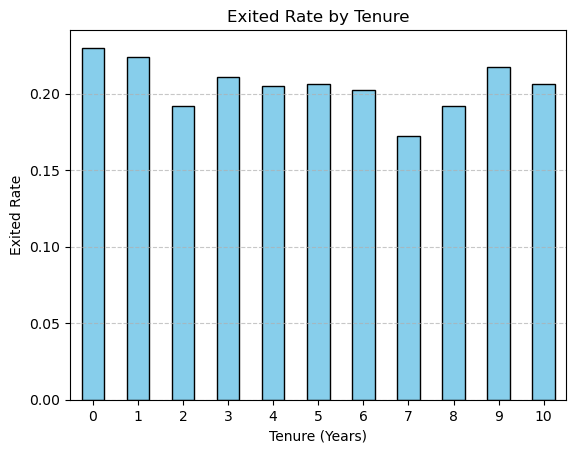

In [37]:
# Tenure별 이탈율
tenure_churn_rate = data2.groupby('Tenure')['Exited'].mean()

# 그래프 시각화
tenure_churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Exited Rate by Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Exited Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- 연도별로 이탈률이 비슷한 추세를 보이고 표본수도 0, 10년차를 제외하면 모두 비슷하다
- **결론**: action에 포함시키지 않는게 좋아보인다.

### 4. Point Earned

In [38]:
# Point Earned의 구간 설정
point_bins = [0, 200, 400, 600, 800, 1001]
point_labels = ['0-200', '200-400', '400-600', '600-800', '800-1000']

# 전체 데이터에서 Point Earned 구간별로 나누기
data['Point_Earned_Binned'] = pd.cut(data['Point Earned'], bins=point_bins, labels=point_labels, right=False)

# 각 구간별 전체 고객 수 계산
total_customers_per_point_bin = data['Point_Earned_Binned'].value_counts().sort_index()

# Exited가 1인 고객들의 각 구간별 이탈 고객 수 계산
exited_customers_per_point_bin = data[data['Exited'] == 1]['Point_Earned_Binned'].value_counts().sort_index()

# 각 구간별 전체 고객 대비 이탈율 계산
exited_rate_per_point_bin = (exited_customers_per_point_bin / total_customers_per_point_bin * 100).round(2)

# 결과 출력
print("Point Earned 구간별 전체 고객 대비 이탈율 (%):")
print(exited_rate_per_point_bin)


Point Earned 구간별 전체 고객 대비 이탈율 (%):
Point_Earned_Binned
0-200       50.00
200-400     20.96
400-600     19.40
600-800     21.41
800-1000    19.79
Name: count, dtype: float64


In [39]:
# 각 구간별 이탈 고객 수
exited_customers_per_point_bin

Point_Earned_Binned
0-200         1
200-400     491
400-600     502
600-800     547
800-1000    497
Name: count, dtype: int64

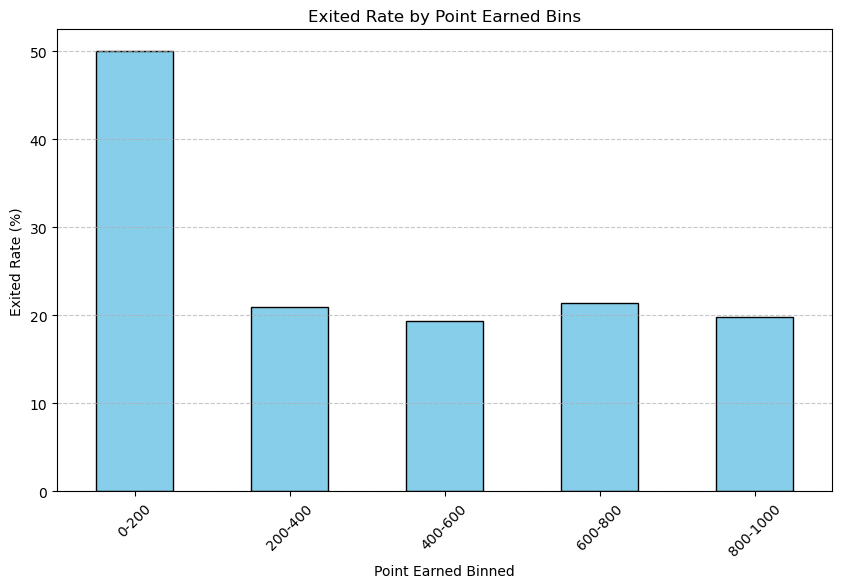

In [40]:
plt.figure(figsize=(10, 6))
exited_rate_per_point_bin.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Exited Rate by Point Earned Bins')
plt.xlabel('Point Earned Binned')
plt.ylabel('Exited Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- 그래프에서는 0~200 구간이 50%로 높게 나타나지만 실질적인 표본수는 2개에 불과하기에 outlier로 판단하고 제외시켜도 무방할것으로 보임
- **해석**: 나머지 구간은 전부 20%정도로 동일하고 표본수또한 비슷하기 때문에 action에 포함시키지 않아도 될것으로 보임
- **예외??**: 보통 포인트들은 이연수익으로 부채로 포함된다. 포인트가 사용되야 부채가 해소되고 카드사의 수익으로 연결되는 구조이지만 고객이 이탈하면 포인트가 소멸되며 그대로 카드사는 아무 손해없이 수익을 얻게된다(당연히 고객이탈 자체가 손해인 경우가 대다수이다). 물론 포인트가 높은 고객의 경우 대부분 은행에 충실한 고객이거나 큰손일 가능성이 높기에 이탈자체가 손해이지만, 혹 다른 feature를 관찰했을때 그렇지 않은 경우라면 붙잡을 이유가 적어지고 이에 따른 reward에 차등을 들 수도 있다.

# 3. Reinforcement Learning Environment Setup

In [41]:
data2.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [42]:
from sklearn.preprocessing import OneHotEncoder

# Drop unnecessary columns
data = data2.drop(columns=['Surname']).reset_index(drop=True)

# Perform OneHotEncoding for 'Geography', 'Gender', and 'Card Type'
categorical_columns = ['Geography', 'Gender', 'Card Type']

# Create OneHotEncoder instance
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform categorical columns
encoded_features = onehot_encoder.fit_transform(data[categorical_columns])

# Get feature names for one-hot encoded columns
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_columns)

# Create DataFrame for one-hot encoded columns
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

# Drop original categorical columns and concatenate encoded DataFrame
data = pd.concat([data.drop(columns=categorical_columns), encoded_df], axis=1)

C:\Users\ikjoo\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
data.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,0.0,0.0,0.0,0.0,0.0,0.0
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,0.0,1.0,0.0,0.0,0.0,0.0
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,0.0,0.0,0.0,0.0,0.0,0.0
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,0.0,0.0,0.0,1.0,0.0,0.0
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,0.0,1.0,0.0,1.0,0.0,0.0


In [53]:
class ChurnEnvironment(gym.Env):
    def __init__(self, data):
        super(ChurnEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)

        self.current_step = 0
        
        self.state_features = list(self.data.drop(columns=['Exited']).columns)
        
        # Define state space as a continuous vector
        self.state_space = spaces.Box(low=0, 
                                      high=np.inf, 
                                      shape=(len(self.state_features),), 
                                      dtype=np.float32)
        

        self.action_space = spaces.Discrete(5)
        self.actions = {
            0: "Personalized Interest Rate Adjustment",
            1: "Customized Product Bundling",
            2: "Age-based Promotion",
            3: "Customized Product Bundle",
            4: "Immediate Personalized Resolution"}
        
    def reset(self):
        """
        Select random customer data as initial state at the start of each episode
        """
        self.current_step = np.random.randint(0, len(self.data))
        return self._get_state()
    
    def _get_state(self):
        """
        Return the current state vector
        """
        state = self.data.loc[self.current_step, self.state_features].values
        return state.astype(np.float32)

    def calculate_reward(self, customer, action):
        reward = 0

        # 1. Personalized Interest Rate Adjustment (완료)
        if action == 0: 
            if customer['CreditScore'] < 579:
                reward += 0.06
            elif 580 <= customer['CreditScore'] <= 669:
                reward += 0.08
            elif 670 <= customer['CreditScore'] <= 739:
                reward += 0.06
            elif 740 <= customer['CreditScore'] <= 799:
                reward += 0.03
            else:
                reward += 0
                

        # 2. Financial Planning Assistance (완료)
        elif action == 1:
            if customer['Balance'] >= 200000:
                reward -= 0.1
            else:
                reward += 0.03

        # 3. Age-based Promotion (완료)
        elif action == 2:
            if customer['Age'] < 40:
                reward += 0.03  
            elif 40 <= customer['Age'] < 50:
                reward -= 0.05  
            elif 50 <= customer['Age'] < 60:
                reward -= 0.1  # Highest churn rate age group
            elif 60 <= customer['Age'] < 70:
                reward -= 0.05
            else:
                reward += 0.03
                
        # 4. Customized Product Bundling (완료)
        elif action == 3:
            if customer['NumOfProducts'] == 1:
                reward += 0.04
            elif customer['NumOfProducts'] == 2:
                reward += 0.08 # 가장 낮은 이탈률을 보여 1보다 높게 포인트 부여
            elif customer['NumOfProducts'] == 3:
                reward -= 0.05  # 제품 수 3개인 경우 페널티
            elif customer['NumOfProducts'] == 4:
                reward -= 0.1  # 제품 수 4개인 경우 강한 페널티    
                
        # 5. Immediate Personalized Resolution (완료)
        # elif action == 4:
        #     if customer['Complain'] == 0:
        #         reward += 0.3
        #     else:
        #         reward -= 2.0

        
        if customer['Exited'] == 0:
            reward += 0.05  # Reward if customer is retained
        else:
            reward -= 0.05 # Penalty if customer has exited
        return reward

    def step(self, action):
        customer = self.data.iloc[self.current_step]
        reward = self.calculate_reward(customer, action) 
        self.current_step += 1
        done = self.current_step >= len(self.data)
        next_state = self._get_state() if not done else np.zeros(self.state_space.shape)
        return next_state, reward, done, {}

In [61]:
import numpy as np
import random
import gym

class QLearning:
    def __init__(self, env,
                 learning_rate=0.1,
                 gamma=0.9,
                 epsilon=1.0,
                 epsilon_decay=0.99,
                 epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((len(env.data), env.action_space.n))
        # 그래프 생성을 위한 reward list
        self.rewards_per_episode = []

    def select_action(self, state_index):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.env.action_space.n - 1)  # 탐험, 무작위로 action을 뽑는다
        else:
            return np.argmax(self.q_table[state_index])  # 최적 행동, 즉 보상을 극대화하는 정책을 선택한다

    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()  
            done = False
            total_reward = 0
            state_index = self.env.current_step  # 현재 상태의 인덱스를 가져옴

            while not done:
                action = self.select_action(state_index)  # 행동 선택
                next_state, reward, done, _ = self.env.step(action)  # 행동 수행 및 보상과 다음 상태 얻기
                next_state_index = self.env.current_step if not done else state_index

                # Q 테이블 업데이트
                old_value = self.q_table[state_index, action]
                next_max = np.max(self.q_table[next_state_index])
                    # 가치 평가를 통해 새로운 value로 업데이트
                self.q_table[state_index, action] = old_value + self.learning_rate * (reward + self.gamma * next_max - old_value)
                
                # 상태 업데이트
                state = next_state
                state_index = next_state_index
                total_reward += reward
                
            # 그래프 생성을 위한 리워드 포인트 누적
            self.rewards_per_episode.append(total_reward)

            # 탐험률 감소
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        print("End")

# 환경 초기화
env = ChurnEnvironment(data)
agent = QLearning(env)
agent.train(num_episodes=400)


Episode 1, Total Reward: 339.7200000000035, Epsilon: 0.99
Episode 2, Total Reward: 507.8399999999908, Epsilon: 0.98
Episode 3, Total Reward: 561.3199999999968, Epsilon: 0.97
Episode 4, Total Reward: 175.67000000000272, Epsilon: 0.96
Episode 5, Total Reward: 358.500000000002, Epsilon: 0.95
Episode 6, Total Reward: 16.090000000000018, Epsilon: 0.94
Episode 7, Total Reward: 539.0299999999933, Epsilon: 0.93
Episode 8, Total Reward: 173.9500000000026, Epsilon: 0.92
Episode 9, Total Reward: 157.21000000000106, Epsilon: 0.91
Episode 10, Total Reward: 306.56000000000546, Epsilon: 0.90
Episode 11, Total Reward: 565.5799999999973, Epsilon: 0.90
Episode 12, Total Reward: 139.6399999999996, Epsilon: 0.89
Episode 13, Total Reward: 8.75, Epsilon: 0.88
Episode 14, Total Reward: 278.2300000000079, Epsilon: 0.87
Episode 15, Total Reward: 595.5599999999985, Epsilon: 0.86
Episode 16, Total Reward: 552.8099999999957, Epsilon: 0.85
Episode 17, Total Reward: 554.3899999999948, Epsilon: 0.84
Episode 18, Tota

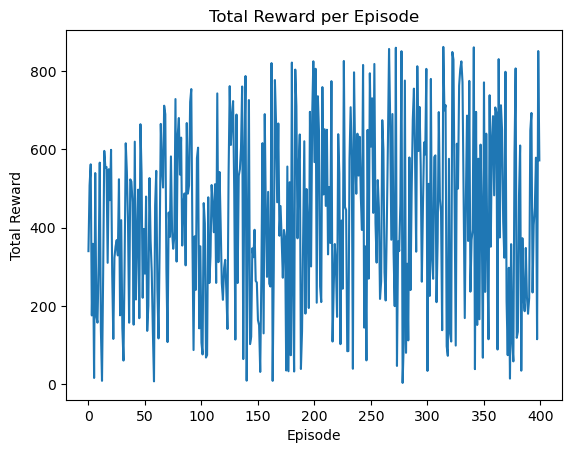

In [62]:
plt.plot(agent.rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()